In [2]:


# Load the dataset files

import numpy as np

# Load dataset files
synthetic_eeg_eog_path = "/home/tulgaa/Desktop/denoisenet/Linear_Mixing/EEG+EOG/Linear_synthetic_eeg_eog.npy"
clean_eeg_path = "/home/tulgaa/Desktop/denoisenet/Linear_Mixing/EEG+EOG/EEG_all_epochs.npy"

# Load the numpy arrays
synthetic_eeg_eog = np.load(synthetic_eeg_eog_path, allow_pickle=True).item()  # Dictionary of SNR levels
clean_eeg = np.load(clean_eeg_path)  # Ground truth EEG

# Inspect dataset keys and shapes
print("🔹 Synthetic EEG+EOG Dictionary Keys (SNR Levels):", synthetic_eeg_eog.keys())
print("🔹 Clean EEG Shape:", clean_eeg.shape)

# Print shape of each SNR level data
for snr in synthetic_eeg_eog.keys():
    print(f"🔹 SNR Level {snr}: Shape = {synthetic_eeg_eog[snr].shape}")

# Check statistics of clean EEG data
print("🔹 Clean EEG Mean:", np.mean(clean_eeg))
print("🔹 Clean EEG Std Dev:", np.std(clean_eeg))


🔹 Synthetic EEG+EOG Dictionary Keys (SNR Levels): dict_keys([-7, -6, -5, -4, -3, -2, -1, 0, 1, 2])
🔹 Clean EEG Shape: (3400, 512)
🔹 SNR Level -7: Shape = (3400, 512)
🔹 SNR Level -6: Shape = (3400, 512)
🔹 SNR Level -5: Shape = (3400, 512)
🔹 SNR Level -4: Shape = (3400, 512)
🔹 SNR Level -3: Shape = (3400, 512)
🔹 SNR Level -2: Shape = (3400, 512)
🔹 SNR Level -1: Shape = (3400, 512)
🔹 SNR Level 0: Shape = (3400, 512)
🔹 SNR Level 1: Shape = (3400, 512)
🔹 SNR Level 2: Shape = (3400, 512)
🔹 Clean EEG Mean: -0.16774763156951383
🔹 Clean EEG Std Dev: 231.82429071340553


In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Step 1: Expand clean EEG dataset (repeat each sample 10 times)
X_clean = np.repeat(clean_eeg, 10, axis=0)  # Shape becomes (34000, 512)

# Step 2: Stack all noisy EEG signals across SNR levels
X_noisy = np.concatenate([synthetic_eeg_eog[snr] for snr in synthetic_eeg_eog.keys()], axis=0)  # (34000, 512)

# Step 3: Normalize the data between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))

X_clean_scaled = scaler.fit_transform(X_clean)  # Normalize clean EEG
X_noisy_scaled = scaler.transform(X_noisy)  # Normalize noisy EEG

# Print dataset details
print(f"✅ Final dataset shapes: Noisy EEG {X_noisy_scaled.shape}, Clean EEG {X_clean_scaled.shape}")
print(f"✅ Clean EEG Mean after Scaling: {np.mean(X_clean_scaled):.4f}, Std Dev: {np.std(X_clean_scaled):.4f}")
print(f"✅ Noisy EEG Mean after Scaling: {np.mean(X_noisy_scaled):.4f}, Std Dev: {np.std(X_noisy_scaled):.4f}")


✅ Final dataset shapes: Noisy EEG (34000, 512), Clean EEG (34000, 512)
✅ Clean EEG Mean after Scaling: -0.0066, Std Dev: 0.2461
✅ Noisy EEG Mean after Scaling: -0.0070, Std Dev: 0.6368


In [4]:
from sklearn.model_selection import train_test_split

# Initialize lists to store train/test sets per SNR
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# Split each SNR level separately to maintain distribution
for snr in synthetic_eeg_eog.keys():
    noisy_snr = synthetic_eeg_eog[snr]  # Noisy EEG data for this SNR level
    clean_snr = clean_eeg[:len(noisy_snr)]  # Ensure correct shape pairing

    # Train-test split (80% train, 20% test)
    X_train_snr, X_test_snr, y_train_snr, y_test_snr = train_test_split(
        noisy_snr, clean_snr, test_size=0.2, random_state=42
    )

    # Store results
    X_train_list.append(X_train_snr)
    X_test_list.append(X_test_snr)
    y_train_list.append(y_train_snr)
    y_test_list.append(y_test_snr)

# Stack data
X_train = np.vstack(X_train_list)
X_test = np.vstack(X_test_list)
y_train = np.vstack(y_train_list)
y_test = np.vstack(y_test_list)

print(f"✅ Final Train Set: Noisy EEG {X_train.shape}, Clean EEG {y_train.shape}")
print(f"✅ Final Test Set: Noisy EEG {X_test.shape}, Clean EEG {y_test.shape}")


✅ Final Train Set: Noisy EEG (27200, 512), Clean EEG (27200, 512)
✅ Final Test Set: Noisy EEG (6800, 512), Clean EEG (6800, 512)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using Device: {device}")

# Define a PyTorch Dataset class
class EEGDataset(Dataset):
    def __init__(self, noisy_data, clean_data):
        self.noisy_data = torch.tensor(noisy_data, dtype=torch.float32).unsqueeze(-1)  # (N, 512, 1)
        self.clean_data = torch.tensor(clean_data, dtype=torch.float32).unsqueeze(-1)  # (N, 512, 1)

    def __len__(self):
        return len(self.noisy_data)

    def __getitem__(self, idx):
        return self.noisy_data[idx], self.clean_data[idx]

# Create DataLoader objects
batch_size = 64
train_dataset = EEGDataset(X_train, y_train)
test_dataset = EEGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the LSTM-based Denoising Model
class LSTMDenoiser(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMDenoiser, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out)
        return out

# Initialize model
model = LSTMDenoiser().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for denoising
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("✅ LSTM Model Ready!")


✅ Using Device: cuda
✅ LSTM Model Ready!


In [6]:
import torch.optim.lr_scheduler as lr_scheduler

# Function to train the model with Early Stopping
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, patience=3):
    model.train()  # Set model to training mode

    best_loss = float("inf")
    early_stop_counter = 0

    # Learning Rate Scheduler (Reduce LR if loss plateaus)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_test_loss = 0.0

        # Training loop
        for noisy_batch, clean_batch in train_loader:
            noisy_batch, clean_batch = noisy_batch.to(device), clean_batch.to(device)

            optimizer.zero_grad()
            outputs = model(noisy_batch)
            loss = criterion(outputs, clean_batch)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Validation loop
        model.eval()
        with torch.no_grad():
            for noisy_batch, clean_batch in test_loader:
                noisy_batch, clean_batch = noisy_batch.to(device), clean_batch.to(device)
                outputs = model(noisy_batch)
                loss = criterion(outputs, clean_batch)
                total_test_loss += loss.item()

        model.train()

        # Calculate average losses
        avg_train_loss = total_train_loss / len(train_loader)
        avg_test_loss = total_test_loss / len(test_loader)

        # Learning rate scheduling
        scheduler.step(avg_test_loss)

        # Print loss for monitoring
        print(f"🔹 Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.6f} | Test Loss: {avg_test_loss:.6f}")

        # Check for early stopping
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            early_stop_counter = 0  # Reset counter
            torch.save(model.state_dict(), "best_lstm_model.pth")  # Save best model
            print("✅ Model Improved! Saving...")
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("⏹️ Early Stopping Triggered. Training Stopped!")
            break

    print("✅ Training Completed!")

# Start Training with Early Stopping
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, patience=3)


/home/tulgaa/anaconda3/envs/medsam/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


🔹 Epoch [1/50] | Train Loss: 49607.725276 | Test Loss: 46194.555892
✅ Model Improved! Saving...
🔹 Epoch [2/50] | Train Loss: 43766.411939 | Test Loss: 41544.491859
✅ Model Improved! Saving...
🔹 Epoch [3/50] | Train Loss: 39521.550097 | Test Loss: 37713.209477
✅ Model Improved! Saving...
🔹 Epoch [4/50] | Train Loss: 36058.282583 | Test Loss: 34824.574164
✅ Model Improved! Saving...
🔹 Epoch [5/50] | Train Loss: 33342.707436 | Test Loss: 32329.058667
✅ Model Improved! Saving...
🔹 Epoch [6/50] | Train Loss: 31090.191912 | Test Loss: 30471.787237
✅ Model Improved! Saving...
🔹 Epoch [7/50] | Train Loss: 29274.891664 | Test Loss: 28806.150993
✅ Model Improved! Saving...
🔹 Epoch [8/50] | Train Loss: 27892.646870 | Test Loss: 27577.422879
✅ Model Improved! Saving...
🔹 Epoch [9/50] | Train Loss: 26632.774894 | Test Loss: 26313.733846
✅ Model Improved! Saving...
🔹 Epoch [10/50] | Train Loss: 25619.275280 | Test Loss: 25659.004180
✅ Model Improved! Saving...
🔹 Epoch [11/50] | Train Loss: 24655.409

In [10]:
import numpy as np
from scipy.stats import pearsonr
from scipy.fftpack import fft

# Function to compute RRMSE
def compute_rrmse(denoised, clean):
    return np.sqrt(np.mean((denoised - clean) ** 2)) / np.sqrt(np.mean(clean ** 2))

# Function to compute RRMSE in the Spectrum Domain
def compute_rrmse_spectrum(denoised, clean):
    fft_clean = np.abs(fft(clean))  # Compute FFT
    fft_denoised = np.abs(fft(denoised))
    return compute_rrmse(fft_denoised, fft_clean)

# Function to compute Correlation Coefficient (CC) (Fixed)
def compute_cc(denoised, clean):
    try:
        return pearsonr(denoised.flatten(), clean.flatten())[0]
    except:
        return 0  # Handle errors gracefully

# Store results
snr_metrics = {}

# Lists to store metrics for computing overall averages
all_rrmse_t = []
all_rrmse_s = []
all_cc = []

# Loop through each SNR level using pre-split test data
with torch.no_grad():
    for snr_idx, snr in enumerate(sorted(synthetic_eeg_eog.keys())):
        print(f"🔹 Evaluating SNR Level: {snr}")

        # Get test data from pre-split dataset
        noisy_snr = X_test_list[snr_idx]  # Noisy EEG
        clean_snr = y_test_list[snr_idx]  # Clean EEG

        # Convert to PyTorch tensors and reshape for LSTM
        noisy_tensor = torch.tensor(noisy_snr, dtype=torch.float32).unsqueeze(-1).to(device)  # (batch, 512, 1)
        clean_tensor = torch.tensor(clean_snr, dtype=torch.float32).unsqueeze(-1).to(device)  # (batch, 512, 1)

        # Get model predictions
        denoised_tensor = model(noisy_tensor).cpu().numpy()
        denoised_tensor = denoised_tensor.reshape(clean_snr.shape)  # Ensure correct shape

        # Compute metrics
        rrmse_t_list = [compute_rrmse(denoised_tensor[i], clean_snr[i]) for i in range(len(clean_snr))]
        rrmse_s_list = [compute_rrmse_spectrum(denoised_tensor[i], clean_snr[i]) for i in range(len(clean_snr))]
        cc_list = [compute_cc(denoised_tensor[i], clean_snr[i]) for i in range(len(clean_snr))]

        # Store results for this SNR level
        snr_metrics[snr] = {
            "RRMSE-T": np.mean(rrmse_t_list),
            "RRMSE-S": np.mean(rrmse_s_list),
            "CC": np.mean(cc_list)
        }

        # Append values for overall averages
        all_rrmse_t.extend(rrmse_t_list)
        all_rrmse_s.extend(rrmse_s_list)
        all_cc.extend(cc_list)

# Compute Overall Averages
overall_rrmse_t = np.mean(all_rrmse_t)
overall_rrmse_s = np.mean(all_rrmse_s)
overall_cc = np.mean(all_cc)

# Print Results in Table Format
print("\n🔹 **Final Evaluation Per SNR Level:**")
print("-----------------------------------------------------")
print("| SNR  |  RRMSE-T  |  RRMSE-S  |   CC   |")
print("-----------------------------------------------------")
for snr in sorted(snr_metrics.keys()):
    print(f"| {snr:3d}  |  {snr_metrics[snr]['RRMSE-T']:.6f}  |  {snr_metrics[snr]['RRMSE-S']:.6f}  |  {snr_metrics[snr]['CC']:.6f}  |")
print("-----------------------------------------------------")

# Print Overall Averages
print("\n🔹 **Overall Averages:**")
print(f"✅ RRMSE-T (Time Domain): {overall_rrmse_t:.6f}")
print(f"✅ RRMSE-S (Spectrum Domain): {overall_rrmse_s:.6f}")
print(f"✅ Correlation Coefficient (CC): {overall_cc:.6f}")


🔹 Evaluating SNR Level: -7
🔹 Evaluating SNR Level: -6
🔹 Evaluating SNR Level: -5
🔹 Evaluating SNR Level: -4
🔹 Evaluating SNR Level: -3
🔹 Evaluating SNR Level: -2
🔹 Evaluating SNR Level: -1
🔹 Evaluating SNR Level: 0
🔹 Evaluating SNR Level: 1
🔹 Evaluating SNR Level: 2

🔹 **Final Evaluation Per SNR Level:**
-----------------------------------------------------
| SNR  |  RRMSE-T  |  RRMSE-S  |   CC   |
-----------------------------------------------------
|  -7  |  0.734336  |  0.464415  |  0.696750  |
|  -6  |  0.689557  |  0.439467  |  0.732662  |
|  -5  |  0.650677  |  0.418035  |  0.762539  |
|  -4  |  0.616681  |  0.398956  |  0.787729  |
|  -3  |  0.586346  |  0.380118  |  0.808972  |
|  -2  |  0.556237  |  0.361166  |  0.828963  |
|  -1  |  0.526407  |  0.342669  |  0.847995  |
|   0  |  0.497460  |  0.325613  |  0.865430  |
|   1  |  0.470608  |  0.309943  |  0.880848  |
|   2  |  0.443812  |  0.294507  |  0.895465  |
-----------------------------------------------------

🔹 **Overa

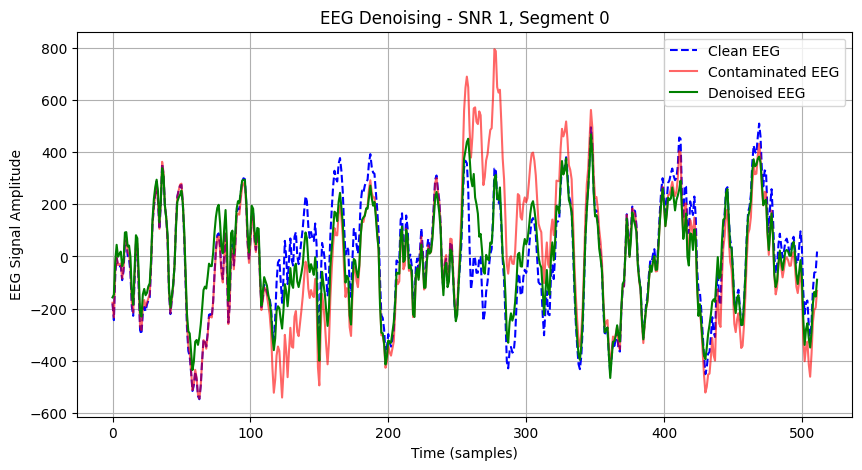

In [11]:
import matplotlib.pyplot as plt

# Select SNR=1 and 0th segment
snr_level = 1
snr_idx = list(sorted(synthetic_eeg_eog.keys())).index(snr_level)  # Find the index of SNR=1

# Get test data
noisy_snr = X_test_list[snr_idx]  # Noisy (contaminated) EEG from test set
clean_snr = y_test_list[snr_idx]  # Clean EEG from test set

# Convert to PyTorch tensor and denoise
noisy_tensor = torch.tensor(noisy_snr, dtype=torch.float32).unsqueeze(-1).to(device)  # (batch, 512, 1)
denoised_tensor = model(noisy_tensor).cpu().detach().numpy()
denoised_tensor = denoised_tensor.reshape(clean_snr.shape)  # Ensure correct shape

# Select the 0th segment (first sample)
segment_idx = 0
noisy_segment = noisy_snr[segment_idx]
clean_segment = clean_snr[segment_idx]
denoised_segment = denoised_tensor[segment_idx]

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(clean_segment, label="Clean EEG", color="blue", linestyle="dashed", linewidth=1.5)
plt.plot(noisy_segment, label="Contaminated EEG", color="red", alpha=0.6)
plt.plot(denoised_segment, label="Denoised EEG", color="green", linewidth=1.5)

plt.xlabel("Time (samples)")
plt.ylabel("EEG Signal Amplitude")
plt.title(f"EEG Denoising - SNR {snr_level}, Segment {segment_idx}")
plt.legend()
plt.grid(True)
plt.show()
